🚀 Starting Random Forest Baseline...
✅ Loaded Data: 4817 rows
📋 Classes Found: ['Cysts_Structural' 'Dysarthia' 'Laryngitis' 'Vox senilis' 'parkinson'
 'spasmodische_dysphonie']

🌲 Training Random Forest Classifier...
✅ Training Complete.

📊 Evaluating on TEST Set...
🏆 Final Accuracy: 81.86%

📝 Classification Report:
                        precision    recall  f1-score   support

      Cysts_Structural       0.88      0.68      0.77        22
             Dysarthia       0.93      0.93      0.93        42
            Laryngitis       0.48      0.60      0.53        42
           Vox senilis       0.79      0.78      0.79        93
             parkinson       0.89      0.92      0.90       200
spasmodische_dysphonie       0.73      0.40      0.52        20

              accuracy                           0.82       419
             macro avg       0.78      0.72      0.74       419
          weighted avg       0.82      0.82      0.82       419



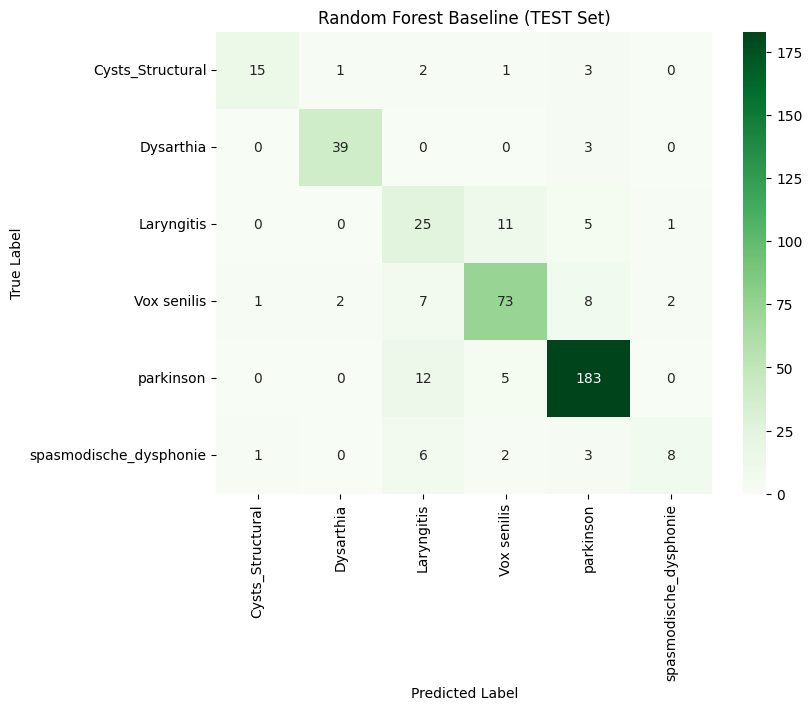

💾 Model saved as 'baseline_random_forest.pkl'


In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. CONFIGURATION ---
SFM_CSV = "sfm_features.csv"  # Ensure this file is in the same folder
SFM_COLS = [
    'jitter_local', 'jitter_rap', 'shimmer_local', 'shimmer_apq3', 
    'hnr', 'f1', 'f2', 'f3', 'f4', 'f0_mean'
]

print("🚀 Starting Random Forest Baseline...")

# --- 2. DATA LOADING ---
try:
    full_df = pd.read_csv(SFM_CSV)
    print(f"✅ Loaded Data: {len(full_df)} rows")
except FileNotFoundError:
    print("❌ Error: 'sfm_features.csv' not found. Please upload it.")
    exit()

# --- 3. DATA PREPARATION ---
# Encode Labels (Text -> Numbers)
label_encoder = LabelEncoder()
full_df['label_encoded'] = label_encoder.fit_transform(full_df['label_name'])
class_names = label_encoder.classes_
print(f"📋 Classes Found: {class_names}")

# Helper function to extract X (Features) and y (Labels) for a specific split
def get_split_data(df, split_name):
    subset = df[df['split'] == split_name]
    if len(subset) == 0:
        return None, None
    
    X = subset[SFM_COLS].values
    y = subset['label_encoded'].values
    return X, y

# Get Train/Val/Test sets
X_train, y_train = get_split_data(full_df, 'train')
X_val, y_val = get_split_data(full_df, 'val')
X_test, y_test = get_split_data(full_df, 'test')

# Handling Missing Values (Crucial for CSVs)
# We fill missing physics numbers with the column mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# We transform Val/Test using the Train statistics (to prevent leakage)
if X_val is not None: X_val = imputer.transform(X_val)
if X_test is not None: X_test = imputer.transform(X_test)

# Scaling (Optional for RF, but good practice)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
if X_val is not None: X_val = scaler.transform(X_val)
if X_test is not None: X_test = scaler.transform(X_test)

# --- 4. TRAIN MODEL ---
print("\n🌲 Training Random Forest Classifier...")
# n_estimators=100: Number of trees
# class_weight='balanced': Helps with rare diseases like Hyperfunctional
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

print("✅ Training Complete.")

# --- 5. EVALUATION ---
# We prefer testing on 'test' set, but fallback to 'val' if test is empty
eval_X = X_test if X_test is not None else X_val
eval_y = y_test if y_test is not None else y_val
set_name = "TEST" if X_test is not None else "VALIDATION"

print(f"\n📊 Evaluating on {set_name} Set...")
y_pred = rf_model.predict(eval_X)

# Accuracy
acc = accuracy_score(eval_y, y_pred)
print(f"🏆 Final Accuracy: {acc*100:.2f}%")

# Detailed Report
print("\n📝 Classification Report:")
print(classification_report(eval_y, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(eval_y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Random Forest Baseline ({set_name} Set)')
plt.show()

# --- 6. SAVE MODEL ---
joblib.dump(rf_model, "baseline_random_forest.pkl")
print("💾 Model saved as 'baseline_random_forest.pkl'")